In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df = pd.read_csv('1.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [ ]:
df['stalk-root']

0       e
1       c
2       c
3       e
4       e
       ..
8119    ?
8120    ?
8121    ?
8122    ?
8123    ?
Name: stalk-root, Length: 8124, dtype: object

In [ ]:
# Test
for col in df.columns:
    data = df[col]=='?'
    if(len(data[data == True])>1):
        print(col,len(data[data == True]))

stalk-root 2480


In [ ]:
df['stalk-root'][df['stalk-root']=='?']=None

In [ ]:
df['stalk-root'].fillna(df['stalk-root'].mode(dropna=True)[0],inplace=True)

In [ ]:
df.shape

(8124, 23)

In [ ]:
train, test = train_test_split(df,test_size=0.2)

In [ ]:
train.shape,test.shape

((6499, 23), (1625, 23))

In [ ]:
def Entropy(DS,response_var):
    P = np.array(DS[response_var].value_counts())
    P = P/sum(P)
    return -sum(P*np.log2(P))

In [ ]:
def IG(S,column,response_var):
    ESv = np.array([Entropy(S[S[column]==value],response_var) for value in set(S[column])])
    Gain = Entropy(S,response_var)-sum(np.array(S[column].value_counts()/len(S)*ESv))
    return Gain

In [ ]:
class Node:
    def __init__(self,column):
        self.column = column
        self.children = {}

In [ ]:
def find_best_column(data,columns,response_var):
    if len(columns)==1:
        return columns[0]
    max = 0
    c = ''
    for col in columns:
        val = IG(data,col,response_var)
        if max<val:
            c = col
            max = val
    return c

In [ ]:
def create_tree(data,predicting_vars,response_var,pruning_depth,d=0):
    if d>=pruning_depth:
        return max(data[response_var])
    if Entropy(data,response_var)==0:
        return max(data[response_var])
        
    col = find_best_column(data,predicting_vars,response_var)
    predicting_vars.remove(col)
    node = Node(col)
    for val in set(data[col]):
        node.children[val] = create_tree(data[data[col]==val],predicting_vars,response_var,pruning_depth,d+1)
    predicting_vars.append(col)
    return node

In [ ]:
dt = create_tree(train,list(df.columns[1:]),'class',len(train.columns))

In [ ]:
# Test
# columns = list(df.columns[1:])
# columns.remove('stalk-root')
# dt = create_tree(train.drop(columns=['stalk-root']),columns,'class')

In [ ]:
def predict(dt,data,response_var):
    tree = dt
    while tree != str(tree):
        tree = tree.children[data[tree.column]]
    return tree

In [ ]:
def get_accuracy(dt,test,response_var):
    l1 = np.array([predict(dt,test.iloc[i],"class") for i in range(len(test))])
    l2 = np.array(test['class'])

    return ((np.count_nonzero(l1==l2))/len(l1))*100

In [ ]:
print("My model accuracy is {}%".format(get_accuracy(dt,test,'class')))

My model accuracy is 100.0%


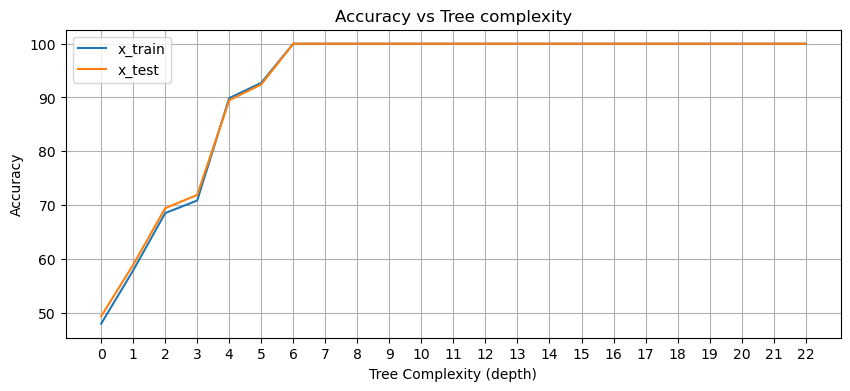

In [ ]:
def display_acc_comp():
    x = np.arange(0,len(train.columns))
    y_n = []
    y_t = []
    for i in x:
        dti = create_tree(train,list(df.columns[1:]),'class',i)
        y_n.append(get_accuracy(dti,test,'class'))
        y_t.append(get_accuracy(dti,train,'class'))
    y_test = np.array(y_n)
    y_train = np.array(y_t)

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x,y_train,label='x_train')
    ax.plot(x,y_test,label='x_test')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlabel('Tree Complexity (depth)')
    plt.title("Accuracy vs Tree complexity")
    plt.xticks(list(range(len(x))),x)
    ax.grid()

display_acc_comp()

In [ ]:
def display_tree(dt,d):
    if dt == str(dt):
        print(dt)
        return
    print(dt.column)
    for k in dt.children.keys():
        print("\t"*(d+1),k,end=":")
        display_tree(dt.children[k],d+1)
        
display_tree(dt,0)

odor
	 s:p
	 m:p
	 p:p
	 a:e
	 f:p
	 c:p
	 y:p
	 l:e
	 n:stalk-root
		 e:e
		 c:p
		 b:gill-attachment
			 a:e
			 f:gill-color
				 p:e
				 e:e
				 h:e
				 r:p
				 w:habitat
					 m:p
					 p:e
					 d:stalk-surface-above-ring
						 s:e
						 y:e
						 k:p
					 w:e
					 l:cap-color
						 c:e
						 w:p
						 n:e
					 g:bruises
						 t:p
						 f:e
				 u:e
				 n:e
				 g:gill-spacing
					 c:p
					 w:e


In [ ]:
import pydot

def draw(graph,parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)

def traverse(graph,tree):
    for c in tree.children.values():
        try:
            draw(graph,tree.column,c.column)
            traverse(graph,c)
        except:
            draw(graph,tree.column,c)

graph = pydot.Dot(graph_type='digraph')
traverse(graph,dt)

In [ ]:
import io
from PIL import Image

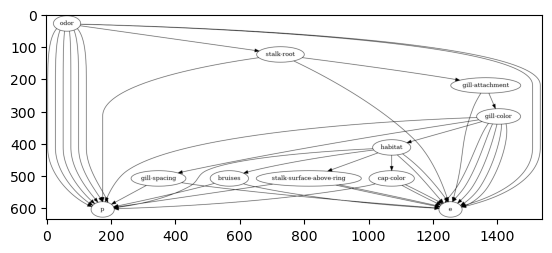

In [ ]:
plt.imshow(np.array(Image.open(io.BytesIO(graph.create_png()))))

# 

# Using Sklearn

In [ ]:
from sklearn.tree import DecisionTreeClassifier

### X,Y Split

In [ ]:
X = df.drop(columns=['class'])
Y = (df['class']=='p').astype(np.int32)

In [ ]:
X

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,k,s,n,f,n,a,c,b,y,e,...,s,o,o,p,o,o,p,b,c,l
8120,x,s,n,f,n,a,c,b,y,e,...,s,o,o,p,n,o,p,b,v,l
8121,f,s,n,f,n,a,c,b,n,e,...,s,o,o,p,o,o,p,b,c,l
8122,k,y,n,f,y,f,c,n,b,t,...,k,w,w,p,w,o,e,w,v,l


In [ ]:
Y

0       1
1       0
2       0
3       1
4       0
       ..
8119    0
8120    0
8121    0
8122    1
8123    0
Name: class, Length: 8124, dtype: int32

In [ ]:
# Test
# X = X.drop(columns='stalk-root')

### Dummy varialbles

In [ ]:
X_new = pd.get_dummies(X,drop_first=True)

In [ ]:
X_new

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0
8121,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0


### Train Test Split

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_new,Y,test_size=0.2)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 3419 to 5365
Data columns (total 94 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   cap-shape_c                 6499 non-null   uint8
 1   cap-shape_f                 6499 non-null   uint8
 2   cap-shape_k                 6499 non-null   uint8
 3   cap-shape_s                 6499 non-null   uint8
 4   cap-shape_x                 6499 non-null   uint8
 5   cap-surface_g               6499 non-null   uint8
 6   cap-surface_s               6499 non-null   uint8
 7   cap-surface_y               6499 non-null   uint8
 8   cap-color_c                 6499 non-null   uint8
 9   cap-color_e                 6499 non-null   uint8
 10  cap-color_g                 6499 non-null   uint8
 11  cap-color_n                 6499 non-null   uint8
 12  cap-color_p                 6499 non-null   uint8
 13  cap-color_r                 6499 non-null   uint8
 14  cap-c

In [ ]:
ml_dt = DecisionTreeClassifier(criterion='entropy')
ml_dt.fit(X_train,Y_train)

DecisionTreeClassifier(criterion='entropy')

In [ ]:
ml_dt.predict(X_test)

array([0, 1, 0, ..., 0, 1, 0], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print("Sklearn model accuracy is {}%".format(accuracy_score(ml_dt.predict(X_test),Y_test)*100))

Sklearn model accuracy is 100.0%


# Comparison

### Accuracy

In [ ]:
print("My model accuracy is {}%".format(get_accuracy(dt,test,'class')))
print("Sklearn model accuracy is {}%".format(accuracy_score(ml_dt.predict(X_test),Y_test)*100))

My model accuracy is 100.0%
Sklearn model accuracy is 100.0%


### Time

In [ ]:
import time as tm

In [ ]:
def find_time(fn):
    start_time = tm.time()
    fn()
    return tm.time()-start_time

def find_avg_time(fn):
    return np.array([find_time(fn) for i in range(10)]).mean()

In [ ]:
def my_model_fit():
    create_tree(train,list(df.columns[:-1]),'class',len(train.columns))

def sklearn_model_fit():
    ml_dt.fit(X_train,Y_train)

In [ ]:
print("My model time is {}s".format(find_avg_time(my_model_fit)))
print("Sklearn model time is {}s".format(find_avg_time(sklearn_model_fit)))

My model time is 0.1896611452102661s
Sklearn model time is 0.014520025253295899s


### Complexity

In [ ]:
from sklearn import tree

[Text(0.5, 0.9285714285714286, 'X[22] <= 0.5\nentropy = 0.999\nsamples = 6499\nvalue = [3378, 3121]'),
 Text(0.23076923076923078, 0.7857142857142857, 'X[17] <= 0.5\nentropy = 0.67\nsamples = 3670\nvalue = [644, 3026]'),
 Text(0.15384615384615385, 0.6428571428571429, 'entropy = 0.0\nsamples = 2587\nvalue = [0, 2587]'),
 Text(0.3076923076923077, 0.6428571428571429, 'X[41] <= 0.5\nentropy = 0.974\nsamples = 1083\nvalue = [644, 439]'),
 Text(0.23076923076923078, 0.5, 'X[43] <= 0.5\nentropy = 0.929\nsamples = 670\nvalue = [231, 439]'),
 Text(0.15384615384615385, 0.35714285714285715, 'X[27] <= 0.5\nentropy = 0.624\nsamples = 520\nvalue = [81, 439]'),
 Text(0.07692307692307693, 0.21428571428571427, 'entropy = 0.0\nsamples = 439\nvalue = [0, 439]'),
 Text(0.23076923076923078, 0.21428571428571427, 'entropy = 0.0\nsamples = 81\nvalue = [81, 0]'),
 Text(0.3076923076923077, 0.35714285714285715, 'entropy = 0.0\nsamples = 150\nvalue = [150, 0]'),
 Text(0.38461538461538464, 0.5, 'entropy = 0.0\nsampl

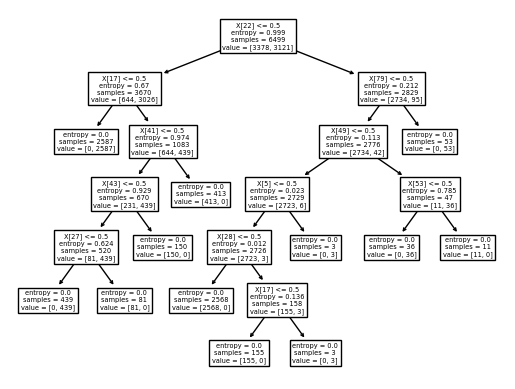

In [ ]:
tree.plot_tree(ml_dt)

In [ ]:
def display_tree(dt,d):
    if dt == str(dt):
        print(dt)
        return
    print(dt.column)
    for k in dt.children.keys():
        print("\t"*(d+1),k,end=":")
        display_tree(dt.children[k],d+1)

display_tree(dt,0)

odor
	 s:p
	 m:p
	 p:p
	 a:e
	 f:p
	 c:p
	 y:p
	 l:e
	 n:stalk-root
		 e:e
		 c:p
		 b:gill-attachment
			 a:e
			 f:gill-color
				 p:e
				 e:e
				 h:e
				 r:p
				 w:habitat
					 m:p
					 p:e
					 d:stalk-surface-above-ring
						 s:e
						 y:e
						 k:p
					 w:e
					 l:cap-color
						 c:e
						 w:p
						 n:e
					 g:bruises
						 t:p
						 f:e
				 u:e
				 n:e
				 g:gill-spacing
					 c:p
					 w:e
